## Import modules

In [1]:
import os, re, glob, cv2, csv
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import tifffile as tiff
import scipy as sp
from scipy import ndimage, io as sio
from scipy.ndimage import maximum_filter, label, find_objects
from scipy.stats import chi2, lognorm, poisson, norm
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import trackpy as tp
import pandas as pd
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
import matplotlib.colors as mcolors
from tqdm import tqdm
from IPython.display import display, Image

from sklearn.manifold import MDS, TSNE
from scipy.stats import zscore, mode
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment

from sklearn.metrics import fowlkes_mallows_score

# Set up matplotlib for animations
rc('animation', html='jshtml')

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # ignore warnings for specific matplotlib commands which will be outdated soon


## Define functions

In [2]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")


def wasserstein_distance(u_samples, v_samples, p=1):
    """
    Computes the 1-Wasserstein or 2-Wasserstein distance between two discrete probability measures.

    Parameters:
    u_samples (array-like): Sample vector for the first distribution.
    v_samples (array-like): Sample vector for the second distribution.
    p (int, optional): Order of the Wasserstein distance. Must be either 1 or 2. Default is 1.

    Returns:
    float: The p-Wasserstein distance between the distributions.
    """
    u_samples_sorted = np.sort(np.asarray(u_samples))
    v_samples_sorted = np.sort(np.asarray(v_samples))
    
    if p == 1:
        all_samples = np.unique(np.concatenate([u_samples_sorted, v_samples_sorted]))
        
        u_cdf = np.searchsorted(u_samples_sorted, all_samples, side='right') / len(u_samples_sorted)
        v_cdf = np.searchsorted(v_samples_sorted, all_samples, side='right') / len(v_samples_sorted)

        return np.sum(np.abs(u_cdf[:-1] - v_cdf[:-1]) * np.diff(all_samples))
    
    elif p == 2:
        u_N = len(u_samples_sorted)
        v_N = len(v_samples_sorted)
        
        all_prob = np.unique(np.concatenate([(np.arange(u_N + 1) / u_N), (np.arange(v_N + 1) / v_N)]))

        u_icdf = np.interp(all_prob[:-1], np.arange(u_N) / u_N, u_samples_sorted)
        v_icdf = np.interp(all_prob[:-1], np.arange(v_N) / v_N, v_samples_sorted)

        return np.sqrt(np.sum((u_icdf - v_icdf) ** 2 * np.diff(all_prob)))
    
    else:
        raise ValueError("Only p=1 or p=2 allowed.")


In [3]:
def compute_wasserstein_distances(df_list, weighted=True, 
                                  velocity_col='inst_velocity', track_duration_col='track_duration', 
                                  file_address_col='file_address'):
    """
    Compute Wasserstein distances within each group and between groups.

    Parameters:
    df_list : list of pandas DataFrames
        List containing DataFrames, each with 'inst_velocity', track duration, and file address columns.
    weighted : bool, default True
        Whether to calculate weighted histograms for each file based on track duration.
    velocity_col : str, default 'inst_velocity'
        The name of the column containing instantaneous velocity values.
    track_duration_col : str, default 'track_duration'
        The name of the column containing track duration values (used for weights if weighted=True).
    file_address_col : str, default 'file_address'
        The name of the column containing file addresses.

    Returns:
    wasserstein_within_groups : list of 2D numpy arrays
        Wasserstein distances computed within each group.
    wasserstein_between_groups : 2D numpy array
        Wasserstein distances computed between the two groups.
    wasserstein_medians : 1D numpy array
        Wasserstein distances between median histograms of groups.
    """
    nbins = 20
    bins = np.arange(0, 40 + 40 / nbins, 40 / nbins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    median_histograms = []
    all_histograms = []

    # Compute histograms for each DataFrame
    for df in df_list:
        histograms = []
        for _, group_data in df.groupby(file_address_col):
            velocities = group_data[velocity_col]
            velocity_weights = group_data[track_duration_col] if weighted else None

            counts, _ = np.histogram(velocities, bins=bins, weights=velocity_weights, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts
            histograms.append(normalized_counts)

        hist_array = np.array(histograms)
        median_histogram = np.median(hist_array, axis=0)
        median_histograms.append(median_histogram)
        all_histograms.append(hist_array)

    # Compute Wasserstein distances within each group
    wasserstein_within_groups = []
    for hist_array in all_histograms:
        num_files = hist_array.shape[0]
        wasserstein_matrix = np.zeros((num_files, num_files))
        for i in range(num_files):
            for j in range(i+1, num_files):
                w_dist = wasserstein_distance(hist_array[i], hist_array[j], p=1)
                wasserstein_matrix[i, j] = w_dist
                wasserstein_matrix[j, i] = w_dist  # Symmetric matrix
        wasserstein_within_groups.append(wasserstein_matrix)

    # Compute Wasserstein distances between groups (pairwise)
    wasserstein_between_groups = np.zeros((all_histograms[0].shape[0], all_histograms[1].shape[0]))
    for i, hist1 in enumerate(all_histograms[0]):
        for j, hist2 in enumerate(all_histograms[1]):
            wasserstein_between_groups[i, j] = wasserstein_distance(hist1, hist2, p=1)

    # Compute Wasserstein distance between median histograms
    wasserstein_medians = np.array([
        wasserstein_distance(median_histograms[0], median_histograms[1])
    ])

    return wasserstein_within_groups, wasserstein_between_groups, wasserstein_medians


## Load data
### 'Early' vs 'Middle' speed values on ridged surfaces

In [120]:
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames')
tp_trajectories_early = pd.read_csv(data_folder+'\\early_stage.csv')
tp_trajectories_middle = pd.read_csv(data_folder+'\\middle_stage.csv')


ws_within_gps, ws_between_gps, ws_medians = compute_wasserstein_distances([tp_trajectories_early, tp_trajectories_middle], weighted=True)

wasserstein_within_early = ws_within_gps[0]; wasserstein_within_middle = ws_within_gps[1]; 
wasserstein_between_groups = ws_between_gps

### Visualize the inter and intra-DIV Wasserstein distances

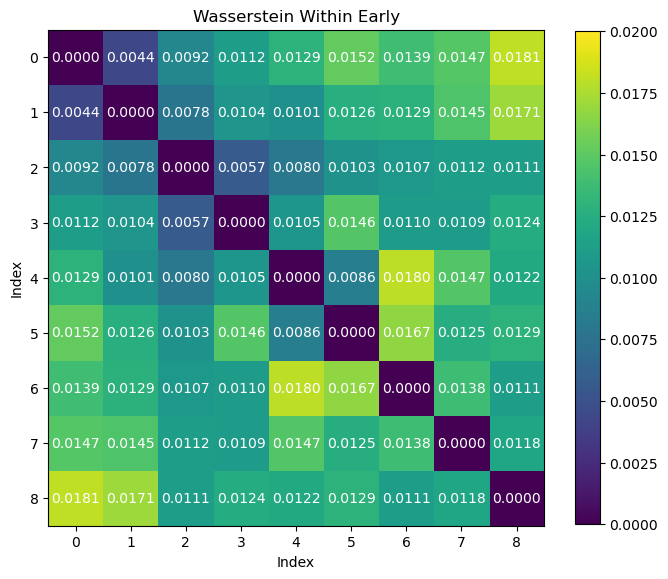

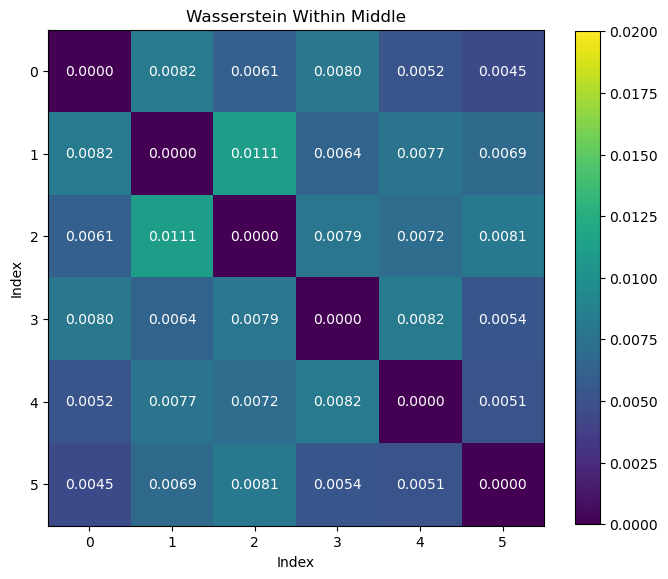

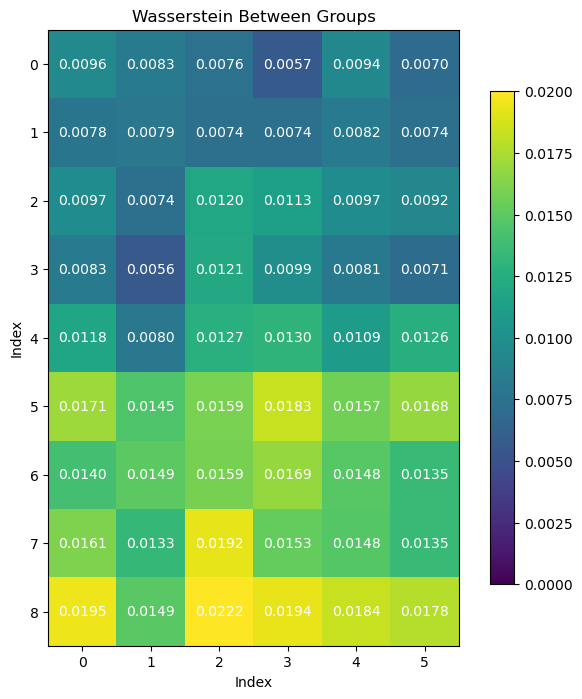

In [121]:
def plot_matrix(matrix, title):
    """Plots a matrix using imshow with values annotated."""
    plt.figure(figsize=(8, 8))
    im = plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmax=0.02, vmin=0.0)
    plt.colorbar(shrink=0.8)
    
    # Annotate values on the matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f"{matrix[i, j]:.4f}", ha='center', va='center', color='white', fontsize=10)

    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Index")
    plt.show()

    # Print matrix values
    # print(f"{title}:\n", matrix, "\n")

# Plot and print each matrix
plot_matrix(wasserstein_within_early, "Wasserstein Within Early")
plot_matrix(wasserstein_within_middle, "Wasserstein Within Middle")
plot_matrix(wasserstein_between_groups, "Wasserstein Between Groups")

## Using MDS for dimension reduction
### MDS using just intra-DIV distances

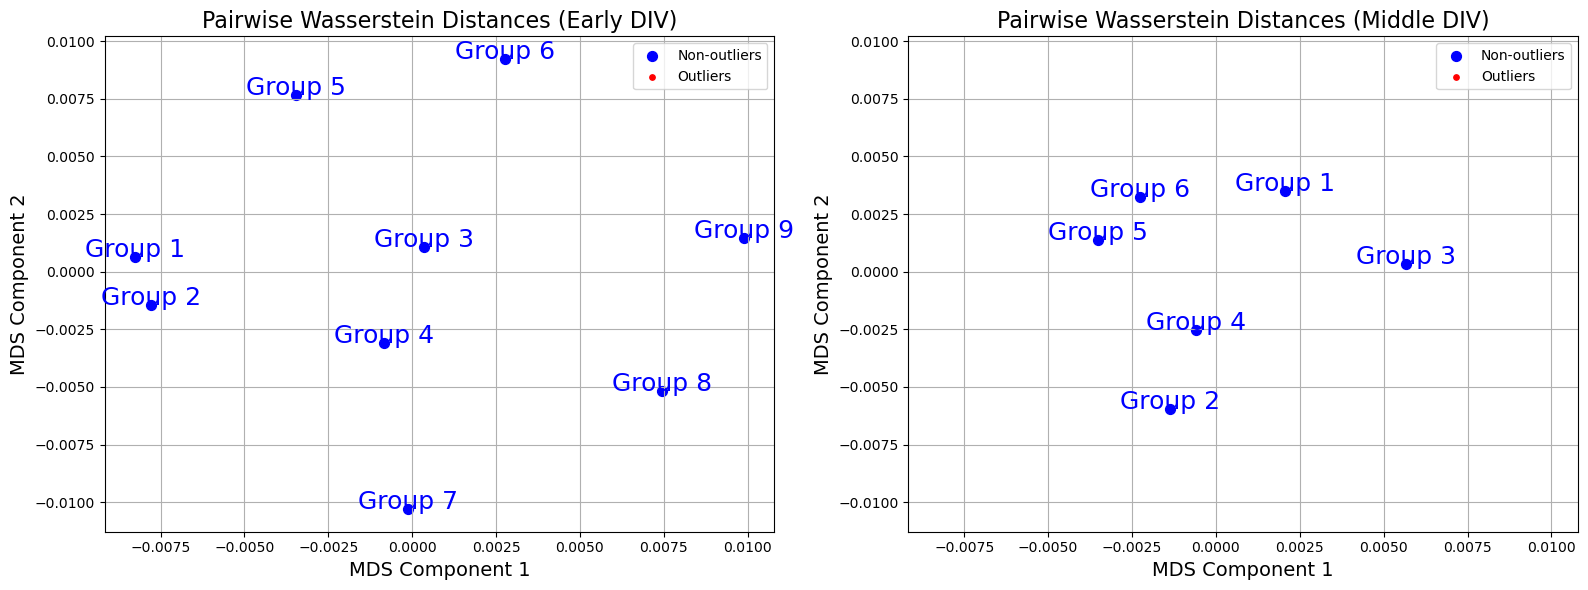

In [132]:
# Use MDS to reduce the (9,9) distance matrix to 2D
mds = MDS(n_components=2, dissimilarity="precomputed")

# Apply MDS to both matrices
positions_early = mds.fit_transform(wasserstein_within_early)
positions_middle = mds.fit_transform(wasserstein_within_middle)

# Calculate z-scores for the MDS components
z_scores_early = np.abs(zscore(positions_early))
z_scores_middle = np.abs(zscore(positions_middle))

# Define a threshold for z-scores (e.g., > 2 standard deviations)
threshold_z = 2

# Identify outliers based on z-scores
outliers_early = np.any(z_scores_early > threshold_z, axis=1)
outliers_middle = np.any(z_scores_middle > threshold_z, axis=1)

# Create a subplot for both early and middle groups
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Find common x and y limits across both MDS results
x_min = min(np.min(positions_early[:, 0]), np.min(positions_middle[:, 0]))
x_max = max(np.max(positions_early[:, 0]), np.max(positions_middle[:, 0]))
y_min = min(np.min(positions_early[:, 1]), np.min(positions_middle[:, 1]))
y_max = max(np.max(positions_early[:, 1]), np.max(positions_middle[:, 1]))

# Plot for 'Within Early' groups
axes[0].scatter(positions_early[:, 0], positions_early[:, 1], color='blue', s = 50, marker='o', label='Non-outliers')
# Highlight outliers in red
axes[0].scatter(positions_early[outliers_early, 0], positions_early[outliers_early, 1], s = 15, color='red', marker='o', label='Outliers')
for i in range(len(wasserstein_within_early)):
    color = 'red' if outliers_early[i] else 'blue'
    axes[0].annotate(f'Group {i+1}', (positions_early[i, 0], positions_early[i, 1]), fontsize=18, ha='center', color=color)

axes[0].set_xlabel('MDS Component 1', fontsize=14)
axes[0].set_ylabel('MDS Component 2', fontsize=14)
axes[0].set_title('Pairwise Wasserstein Distances (Early DIV)', fontsize=16)
axes[0].grid(True)
axes[0].legend()
# Define a small offset (e.g., 5% of the range)
x_offset = (x_max - x_min) * 0.05
y_offset = (y_max - y_min) * 0.05

# Apply the offset to the limits
axes[0].set_xlim(x_min - x_offset, x_max + x_offset)
axes[0].set_ylim(y_min - y_offset, y_max + y_offset)

# Similarly, apply the offset to the second axis
axes[1].set_xlim(x_min - x_offset, x_max + x_offset)
axes[1].set_ylim(y_min - y_offset, y_max + y_offset)


# Plot for 'Within Middle' groups
axes[1].scatter(positions_middle[:, 0], positions_middle[:, 1], color='blue', s = 50, marker='o', label='Non-outliers')
# Highlight outliers in red
axes[1].scatter(positions_middle[outliers_middle, 0], positions_middle[outliers_middle, 1], s = 15, color='red', marker='o', label='Outliers')
for i in range(len(wasserstein_within_middle)):
    color = 'red' if outliers_middle[i] else 'blue'
    axes[1].annotate(f'Group {i+1}', (positions_middle[i, 0], positions_middle[i, 1]), fontsize=18, ha='center', color=color)

axes[1].set_xlabel('MDS Component 1', fontsize=14)
axes[1].set_ylabel('MDS Component 2', fontsize=14)
axes[1].set_title('Pairwise Wasserstein Distances (Middle DIV)', fontsize=16)
axes[1].grid(True)
axes[1].legend()


# Apply the offset to the limits
axes[0].set_xlim(x_min - x_offset, x_max + x_offset)
axes[0].set_ylim(y_min - y_offset, y_max + y_offset)

# Similarly, apply the offset to the second axis
axes[1].set_xlim(x_min - x_offset, x_max + x_offset)
axes[1].set_ylim(y_min - y_offset, y_max + y_offset)


# Show the plot
plt.tight_layout()
plt.show()


## MDS using both intra-inter DIV distances

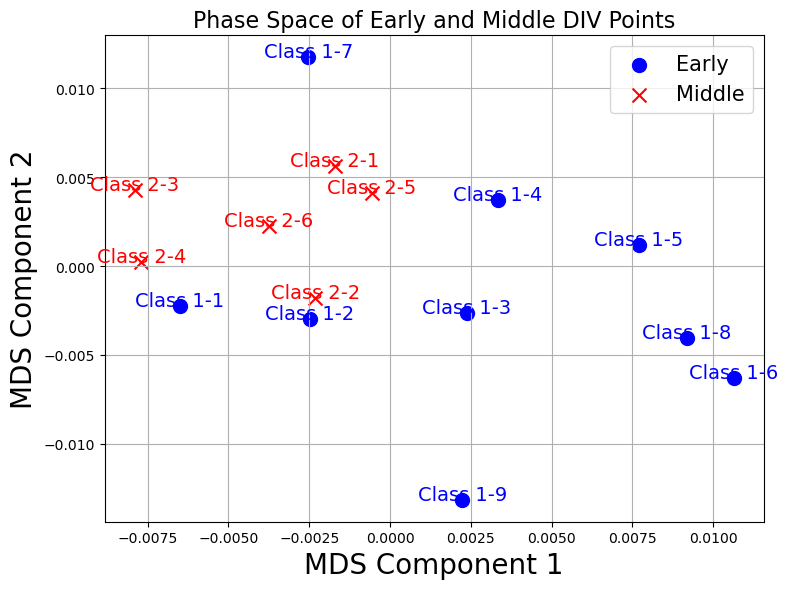

In [175]:
D1 = wasserstein_within_early
D2 = wasserstein_within_middle
D12 = wasserstein_between_groups

# Create the combined distance matrix
combined_distance_matrix = np.zeros((15, 15))

# Fill the top-left (D1), bottom-right (D2), and top-right/bottom-left (D12) blocks
combined_distance_matrix[:9, :9] = D1
combined_distance_matrix[9:, 9:] = D2
combined_distance_matrix[:9, 9:] = D12
combined_distance_matrix[9:, :9] = D12.T  # Transpose for symmetric matrix

# Apply MDS to the combined distance matrix
mds = MDS(n_components=2, dissimilarity="precomputed")
positions = mds.fit_transform(combined_distance_matrix)

# Create a structured array with the points and labels
labels = np.array([0] * 9 + [1] * 6)  # True class labels
points = np.column_stack((positions, labels))  # Combine position and label into a structured array

# Plot the points in 2D phase space
plt.figure(figsize=(8, 6))

# Plot points from class-1 (first 9 points)
plt.scatter(positions[:9, 0], positions[:9, 1], color='blue', s=100, marker='o', label='Early')

# Plot points from class-2 (next 6 points)
plt.scatter(positions[9:, 0], positions[9:, 1], color='red', s=100, marker='x', label='Middle')

# Annotate the points with the class label
for i in range(9):
    plt.annotate(f'Class 1-{i+1}', (positions[i, 0], positions[i, 1]), fontsize=14, ha='center', color='blue')

for i in range(6):
    plt.annotate(f'Class 2-{i+1}', (positions[9 + i, 0], positions[9 + i, 1]), fontsize=14, ha='center', color='red')

# Customize the plot
plt.xlabel('MDS Component 1', fontsize=20)
plt.ylabel('MDS Component 2', fontsize=20)
plt.title('Phase Space of Early and Middle DIV Points', fontsize=16)
plt.legend(fontsize=15)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# You now have a structured array `points` containing the MDS positions and labels
# You can access the positions and true labels easily for later comparison


## Using t-SNE for dimension reduction

C:\Users\spandanp\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Correctly classified (Group 0): 7
Misclassified (Group 0 as Group 1): 2
Correctly classified (Group 1): 5
Misclassified (Group 1 as Group 0): 1


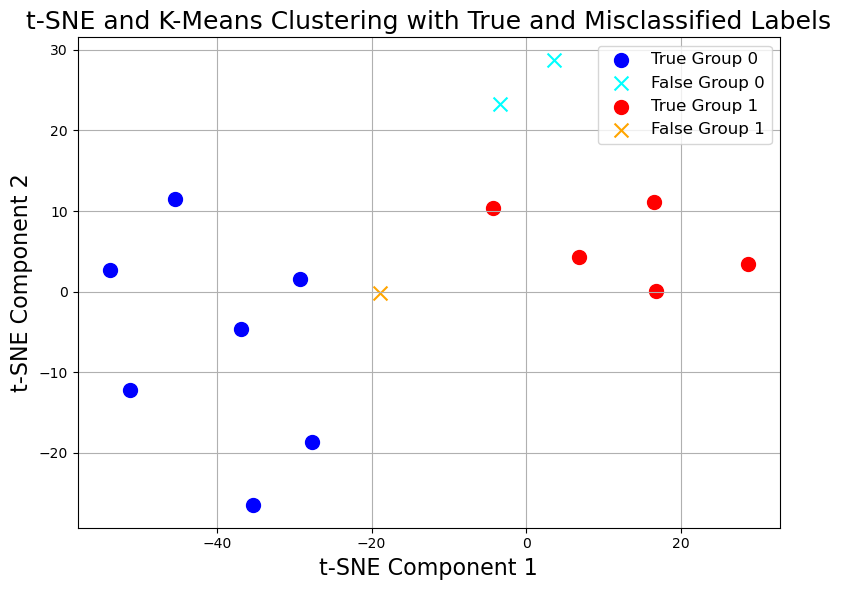

In [171]:
D1 = wasserstein_within_early
D2 = wasserstein_within_middle
D12 = wasserstein_between_groups

# Step 1: Create the combined distance matrix
combined_distance_matrix = np.zeros((15, 15))
combined_distance_matrix[:9, :9] = D1
combined_distance_matrix[9:, 9:] = D2
combined_distance_matrix[:9, 9:] = D12
combined_distance_matrix[9:, :9] = D12.T  # Ensure symmetry

# Apply t-SNE
tsne = TSNE(n_components=2, metric="precomputed", perplexity=5, init='random', random_state=42)
positions = tsne.fit_transform(combined_distance_matrix)

# Define true labels based on the groups
# True labels for early and middle (change based on how you group your data)
true_labels = np.array([0] * 9 + [1] * 6)

# Apply K-Means Clustering on the t-SNE positions
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
predicted_labels = kmeans.fit_predict(positions)

# Find Best Label Assignment Using Hungarian Algorithm
contingency_matrix = np.zeros((2, 2))

# Calculate contingency matrix (confusion matrix for clustering)
for i in range(2):
    for j in range(2):
        contingency_matrix[i, j] = np.sum((predicted_labels == i) & (true_labels == j))

row_ind, col_ind = linear_sum_assignment(-contingency_matrix)  # Maximize matching

# Align predicted labels based on the best mapping
predicted_labels_aligned = np.array([label_mapping[label] for label in predicted_labels])


# Identify correctly and incorrectly classified points
true_group_0 = (true_labels == 0) & (predicted_labels_aligned == 0)
false_group_0 = (true_labels == 0) & (predicted_labels_aligned == 1)
true_group_1 = (true_labels == 1) & (predicted_labels_aligned == 1)
false_group_1 = (true_labels == 1) & (predicted_labels_aligned == 0)

# Print classification counts
print(f"Correctly classified (Group 0): {np.sum(true_group_0)}")
print(f"Misclassified (Group 0 as Group 1): {np.sum(false_group_0)}")
print(f"Correctly classified (Group 1): {np.sum(true_group_1)}")
print(f"Misclassified (Group 1 as Group 0): {np.sum(false_group_1)}")

# Visualize the results with True and Predicted Labels
plt.figure(figsize=(8, 6))

# Plot true labels
plt.scatter(positions[true_group_0, 0], positions[true_group_0, 1], c='blue', s=100, marker='o', label='True Group 0')
plt.scatter(positions[false_group_0, 0], positions[false_group_0, 1], c='cyan', s=100, marker='x', label='False Group 0')
plt.scatter(positions[true_group_1, 0], positions[true_group_1, 1], c='red', s=100, marker='o', label='True Group 1')
plt.scatter(positions[false_group_1, 0], positions[false_group_1, 1], c='orange', s=100, marker='x', label='False Group 1')

# Customize plot labels and title
plt.xlabel('t-SNE Component 1', fontsize=16)
plt.ylabel('t-SNE Component 2', fontsize=16)
plt.title('t-SNE and K-Means Clustering with True and Misclassified Labels', fontsize=18)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### Real and k-means labels side-by-side

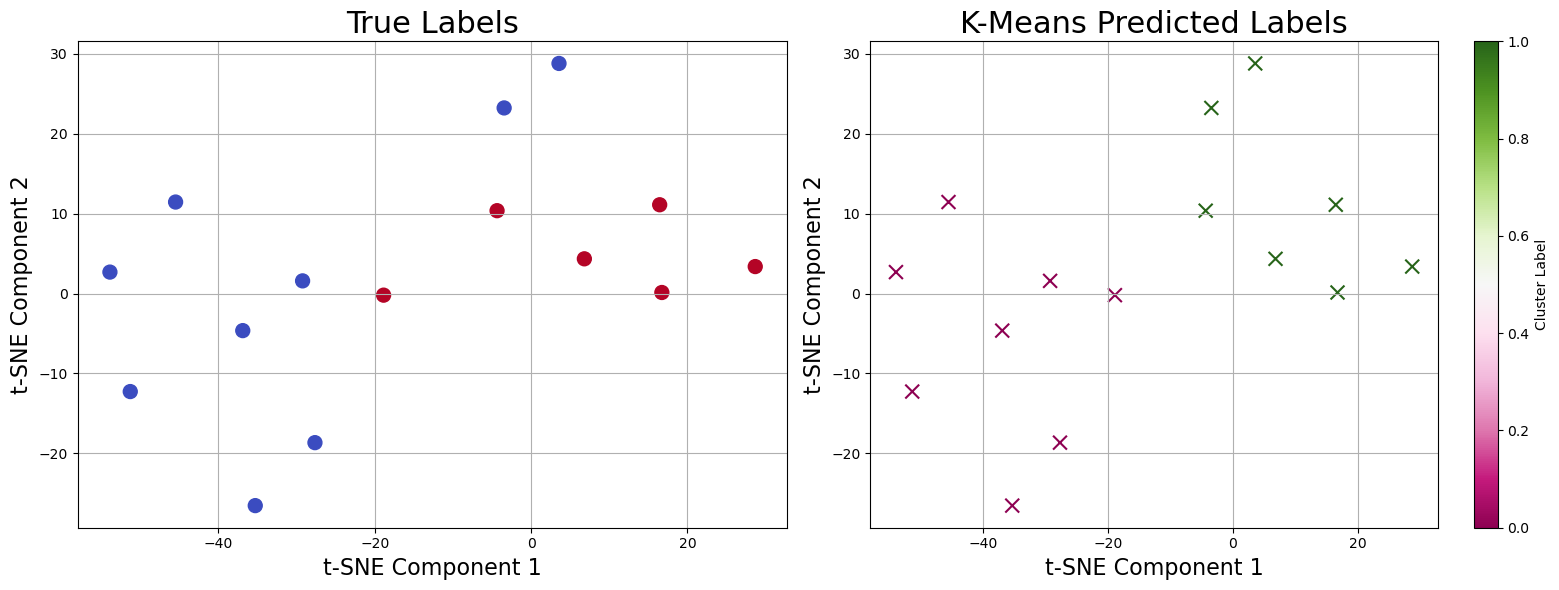

Fowlkes-Mallows Index (FMI): 0.6401


In [152]:
# Create a DataFrame to show true labels and predicted labels
labels_comparison = pd.DataFrame({
    'True Labels': true_labels,
    'K-means Predicted Labels': predicted_labels
})

# print(labels_comparison)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot using true labels for the first subplot
ax[0].scatter(positions[:, 0], positions[:, 1], c=true_labels, cmap='coolwarm', s=100, marker='o')
ax[0].set_title('True Labels', fontsize=22)
ax[0].set_xlabel('t-SNE Component 1', fontsize=16)
ax[0].set_ylabel('t-SNE Component 2', fontsize=16)
ax[0].grid(True)

# Scatter plot using K-means predicted labels for the second subplot
scatter = ax[1].scatter(positions[:, 0], positions[:, 1], c=predicted_labels, cmap='PiYG', s=100, marker='x')
ax[1].set_title('K-Means Predicted Labels', fontsize=22)
ax[1].set_xlabel('t-SNE Component 1', fontsize=16)
ax[1].set_ylabel('t-SNE Component 2', fontsize=16)
ax[1].grid(True)

# Add colorbar to the second plot for K-means predicted labels
fig.colorbar(scatter, ax=ax[1], label='Cluster Label')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

fmi = fowlkes_mallows_score(true_labels, predicted_labels)
# FMI is a measure of the similarity between the true labels and predicted clusters.
print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")

### Compute Fowlkes-Mallows Index for 100 runs

In [159]:
# Example data (replace these with your actual matrices)
D1 = wasserstein_within_early
D2 = wasserstein_within_middle
D12 = wasserstein_between_groups

# True labels (from your ground truth)
true_labels = np.array([0] * 9 + [1] * 6)  # Class 1 = 0, Class 2 = 1

# Number of iterations
N = 100

# Store FMI scores
fmi_scores = []

# Step 1: Create the combined distance matrix
combined_distance_matrix = np.zeros((15, 15))
combined_distance_matrix[:9, :9] = D1
combined_distance_matrix[9:, 9:] = D2
combined_distance_matrix[:9, 9:] = D12
combined_distance_matrix[9:, :9] = D12.T  # Ensure symmetry

# Loop N times
for _ in range(N):
    # Step 2: Apply MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=None)
    positions = mds.fit_transform(combined_distance_matrix)
    
    # Step 3: Apply K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, algorithm='elkan')  # Use a fixed random_state for reproducibility
    cluster_labels = kmeans.fit_predict(positions)
    
    # Step 4: Compare with ground truth using Fowlkes-Mallows Index (FMI)
    fmi = fowlkes_mallows_score(true_labels, cluster_labels)  # Clustering performance
    fmi_scores.append(fmi)

# After the loop, you can analyze the FMI scores
average_fmi = np.mean(fmi_scores)
print(f"Average Fowlkes-Mallows Index (FMI) over {N} iterations: {average_fmi:.4f}")


Average Fowlkes-Mallows Index (FMI) over 100 iterations: 0.6207


### Plot the distribution of FMI

Mean Fowlkes-Mallows Index (FMI) over 100 runs: 0.6207


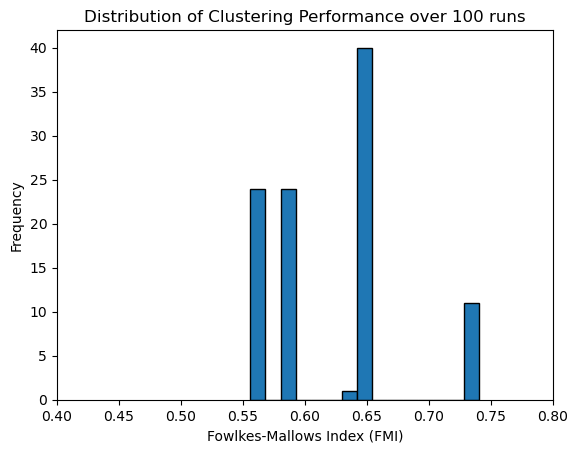

In [165]:
# Print the mean FMI score
print(f"Mean Fowlkes-Mallows Index (FMI) over {N} runs: {np.mean(fmi_scores):.4f}")

# Plot the distribution of FMI scores
plt.hist(fmi_scores, bins=15, edgecolor='black')
plt.xlabel("Fowlkes-Mallows Index (FMI)")
plt.xlim([0.4,0.8])
plt.ylabel("Frequency")
plt.title("Distribution of Clustering Performance over 100 runs")
plt.show()


C:\Users\spandanp\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\spandanp\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\spandanp\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\spandanp\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.p

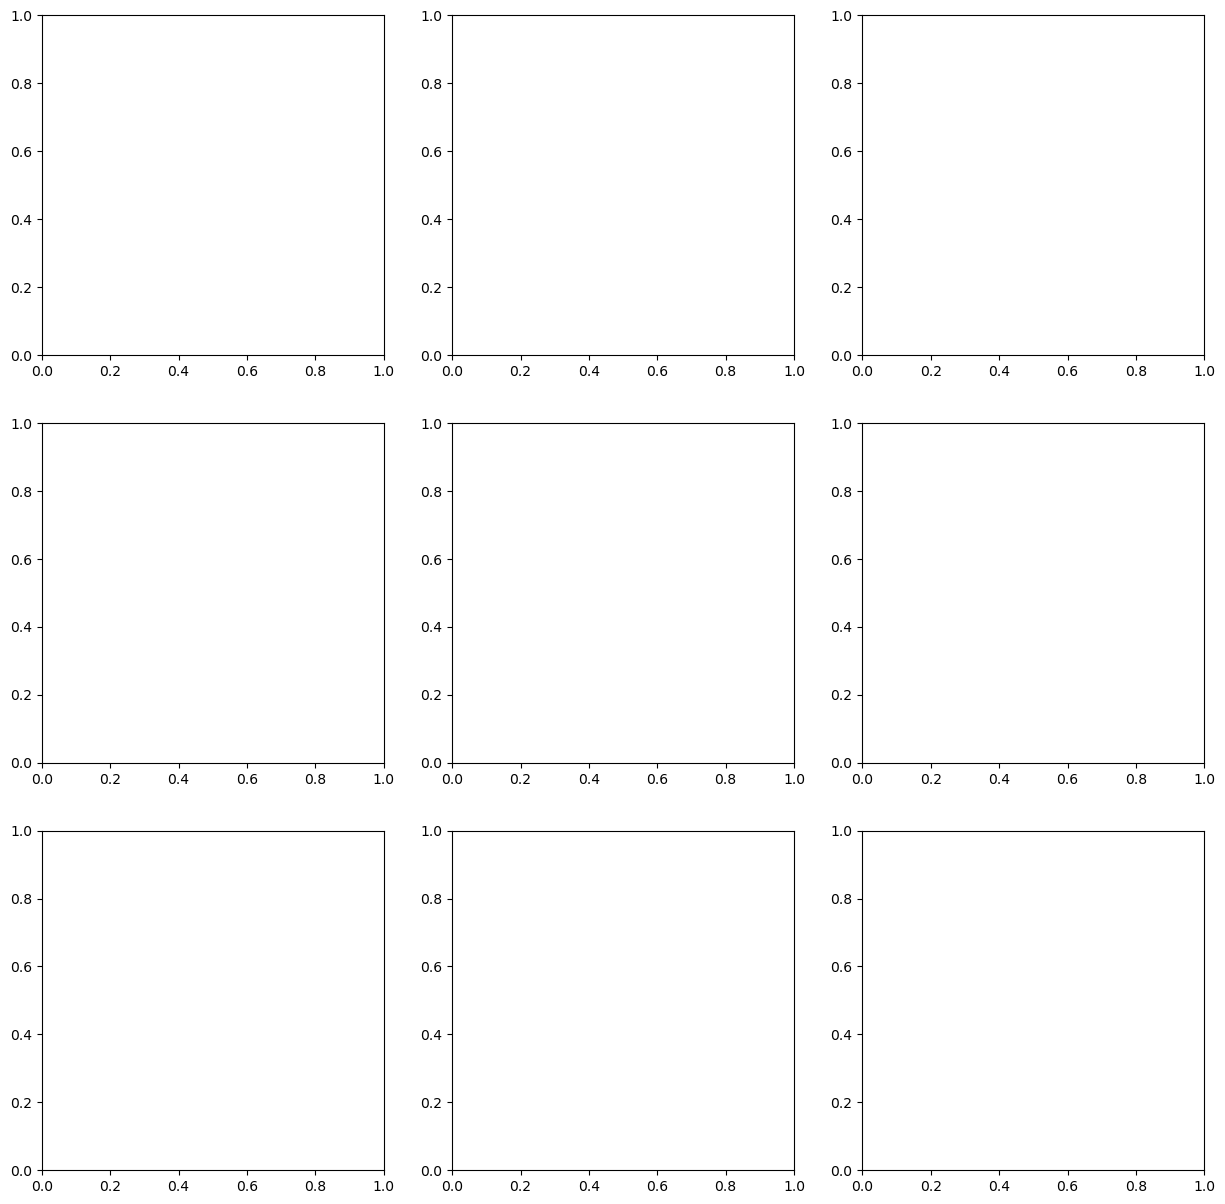

In [167]:
from matplotlib.colors import ListedColormap

# Number of iterations
N = 100

# Store clustering accuracy and results
fmi_scores = []
results = []

# Combine the distance matrices
combined_distance_matrix = np.zeros((15, 15))
combined_distance_matrix[:9, :9] = D1
combined_distance_matrix[9:, 9:] = D2
combined_distance_matrix[:9, 9:] = D12
combined_distance_matrix[9:, :9] = D12.T  # Ensure symmetry

# True class labels (truth values)
true_labels = np.array([0] * 9 + [1] * 6)  # Class 1 = 0, Class 2 = 1

# Loop N times
for i in range(N):
    # Step 2: Apply MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=i)
    positions = mds.fit_transform(combined_distance_matrix)
    
    # Step 3: Apply K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=i, n_init=10, algorithm='lloyd')
    cluster_labels = kmeans.fit_predict(positions)
    
    # Step 4: Compare with ground truth (true_labels)
    fmi = fowlkes_mallows_score(true_labels, cluster_labels)  # Clustering performance (FMI)
    fmi_scores.append(fmi)
    results.append((positions, cluster_labels, fmi))  # Store positions and labels for later use

# Sort the results based on FMI scores (from worst to best)
sorted_results = sorted(zip(fmi_scores, results), key=lambda x: x[0])

